In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import cm
from matplotlib.ticker import LinearLocator
from scipy.stats import norm
from scipy.stats import multivariate_normal

# 1) Slice Sampling for 1-D Target Distribution

In [2]:
T = 10000
W = 1
xMin, xMax = -10, 12
x, u = np.zeros((T, 1)), np.zeros((T, 1))

# define the target distribution: bi-modal normal density
def p(x):
    return 0.3 * norm.pdf(x, -3, 1.5) + 0.7 * norm.pdf(x, 5, 1.5)

x[0] = np.random.uniform(xMin, xMax)
maxiter = 200

for t in range(1, T):
    iter_ = 0

    # select a random height at the vertical slice
    u[t-1] = np.random.uniform(0, p(x[t-1]))

    # set the interval around the current point
    r = np.random.uniform(0, 1)
    xL = np.max([xMin, (x[t-1]-r*W)[0]])
    xR = np.min([xMax, xL+W])

    while (u[t-1] < p(xL))[0] & (iter_ < maxiter):
        xL = np.max([xMin, xL-W])
        iter_ += 1

    while (u[t-1] < p(xR))[0] & (iter_ < maxiter):
        xR = np.min([xMax, xR+W])
        iter_ += 1

    if iter_ > maxiter:
        print('error in stepping out')


    # accept/reject samples from within S
    while iter_ < maxiter:
        # sample a candidate point from the horizontal slice
        xStar = np.random.uniform(xL, xR)

        # accetp the candidate point if p(xStar) is higher than the height u
        if u[t-1] < p(xStar):
            x[t] = xStar
            iter_ += 1
            break

        # adjust either the lower or upper bound (shrinking)
        if xStar < x[t-1]:
            xL = xStar
            iter_ += 1
        else:
            xR = xStar
            iter_ += 1

    if iter_ > maxiter:
        print('error in shrinkage')

In [3]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size/2:]

In [4]:
def autocorr1(x, lags):
    '''numpy.corrcoef, partial'''
    x = x.ravel()
    corr = [1. if l==0 else np.corrcoef(x[l:], x[:-l])[0][1] for l in lags]
    return np.array(corr)

Text(0.5, 1.0, 'Sample Autocorrelation Function')

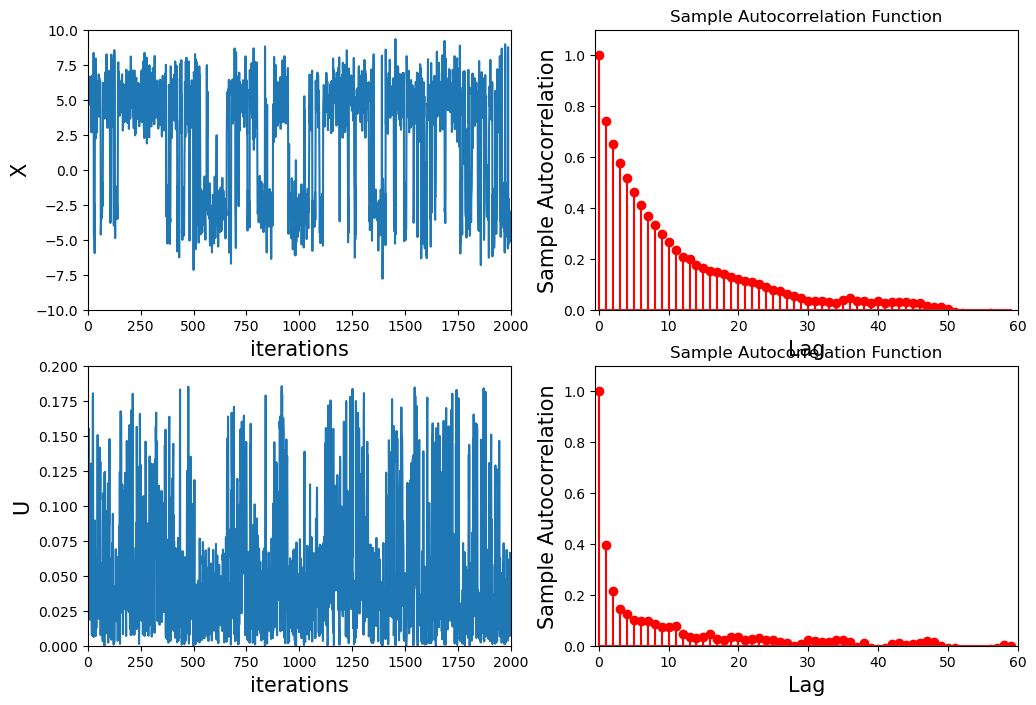

In [5]:
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.plot(np.arange(T), x)
plt.xlabel('iterations', fontsize=15)
plt.ylabel('X', fontsize=15)
plt.xlim((0, 2000))
plt.ylim((-10, 10))

plt.subplot(222)
plt.stem(np.arange(60), autocorr1(x, np.arange(60)), linefmt ='r', markerfmt='ro')
plt.xlabel('Lag', fontsize=15)
plt.ylabel('Sample Autocorrelation', fontsize=15)
plt.xlim((-0.5, 60))
plt.ylim((0, 1.1))
plt.title('Sample Autocorrelation Function')

plt.subplot(223)
plt.plot(np.arange(T), u)
plt.xlabel('iterations', fontsize=15)
plt.ylabel('U', fontsize=15)
plt.xlim((0, 2000))
plt.ylim((0, 0.2))

plt.subplot(224)
plt.stem(np.arange(60), autocorr1(u, np.arange(60)), linefmt ='r', markerfmt='ro')
plt.xlabel('Lag', fontsize=15)
plt.ylabel('Sample Autocorrelation', fontsize=15)
plt.xlim((-0.5, 60))
plt.ylim((0, 1.1))
plt.title('Sample Autocorrelation Function')

(0.0, 0.2)

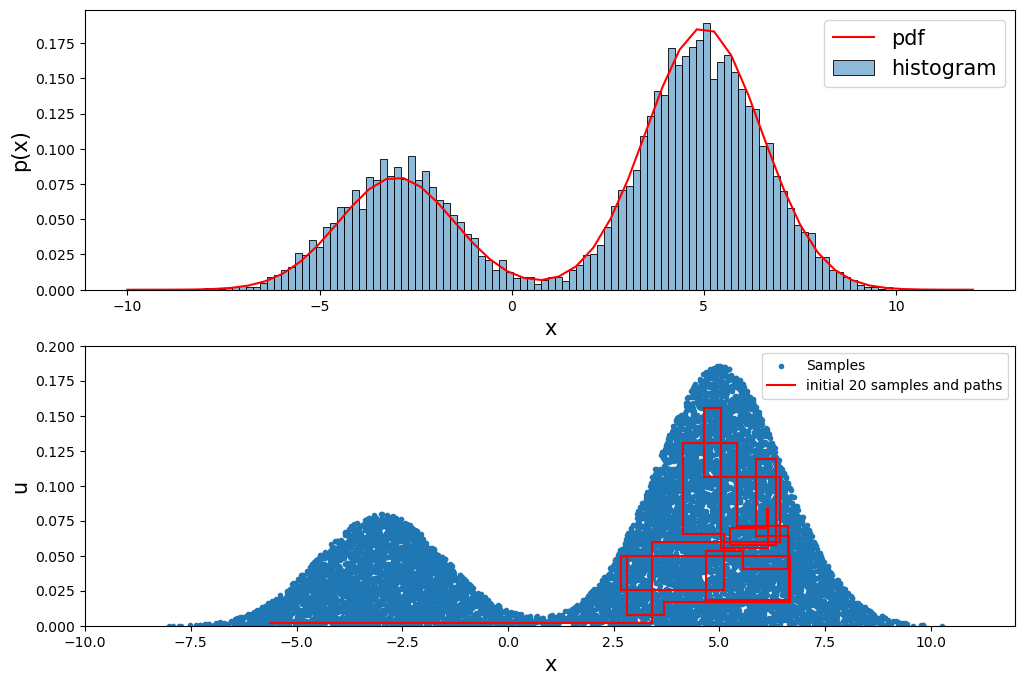

In [6]:
plt.figure(figsize = (12, 8))
plt.subplot(2,1,1)
nbins = 50
sns.histplot(data=x, stat='density', bins=100)
plt.plot(np.linspace(xMin, xMax, nbins), p(np.linspace(xMin, xMax, nbins)), 'r-')
plt.legend(['pdf', 'histogram'], fontsize = 15)
plt.xlabel('x', fontsize = 15)
plt.ylabel('p(x)', fontsize = 15)

plt.subplot(2,1,2)
plt.scatter(x, u, marker = '.')
for t in range(20):
    plt.plot([x[t], x[t+1]], [u[t], u[t]], 'r-')
    plt.plot([x[t+1], x[t+1]], [u[t], u[t+1]], 'r-')

plt.legend(['Samples', 'initial 20 samples and paths'])
plt.xlabel('x', fontsize = 15)
plt.ylabel('u', fontsize = 15)
plt.xlim([-10, 12])
plt.ylim([0, 0.2])

# 2) (w/o Stepping-Out) Slice Sampling for 2-D Normal Distribution

In [7]:
T = 5000
d = 2

# target distribution: bi-variate normal distribution with correlation
pMu = np.array([0.5, 1.5])
pSigma = np.array([[1, 0.95], [0.95, 1]])

def p(x):
    return multivariate_normal(mean=pMu, cov=pSigma).pdf(x)

x = np.zeros((T, d))
xL, xR, W, r = np.zeros((1, d)), np.zeros((1, d)), np.zeros((1, d)), np.zeros((1, d))

# ranges from each sample space
xMin = np.array([-3, -4])
xMax = np.array([4, 6])
# initial step sizes (width) for each variable
W = np.array([1, 1])

# select initial points for each sample spaceb
x[0, :] = [-1, 4]
maxiter = 200


for t in range(1, T):
    iter_ = 0

    # selet a random height at the vertical slice (log-scale)
    u[t-1] = np.exp( np.log( p(x[t-1,:]) ) - np.random.exponential(1) )

    # for each dimension
    # set the intervals of hyper-rectangle around the current point
    r = np.random.uniform(0, 1, d)
    xL = np.max(np.concatenate(([xMin], [x[t-1,:]-np.multiply(r, W)]), axis=0), axis=0)
    xR = np.min(np.concatenate(([xMax], [xL+W]), axis=0), axis=0)

    ######## w/o stepping out #########

    # accept/reject samples from within S
    while 1:
        # draw candidate sample points from the horizontal slice for each dimension
        xStar = np.random.uniform(xL, xR)

        # evaluate the pdf and determine accepting the candidate point
        if u[t-1] < np.exp( np.log( p(xStar) )):
            x[t,:] = xStar
            break

        # shrinkage procedure
        # modify either the lower or upper end of the interval for each dimension
        for j in range(d):
            if xStar[j] < x[t-1, j]:
                xL[j] = xStar[j]
            else:
                xR[j] = xStar[j]

xx, yy = x[:,0], x[:,1]

(-4.0, 6.0)

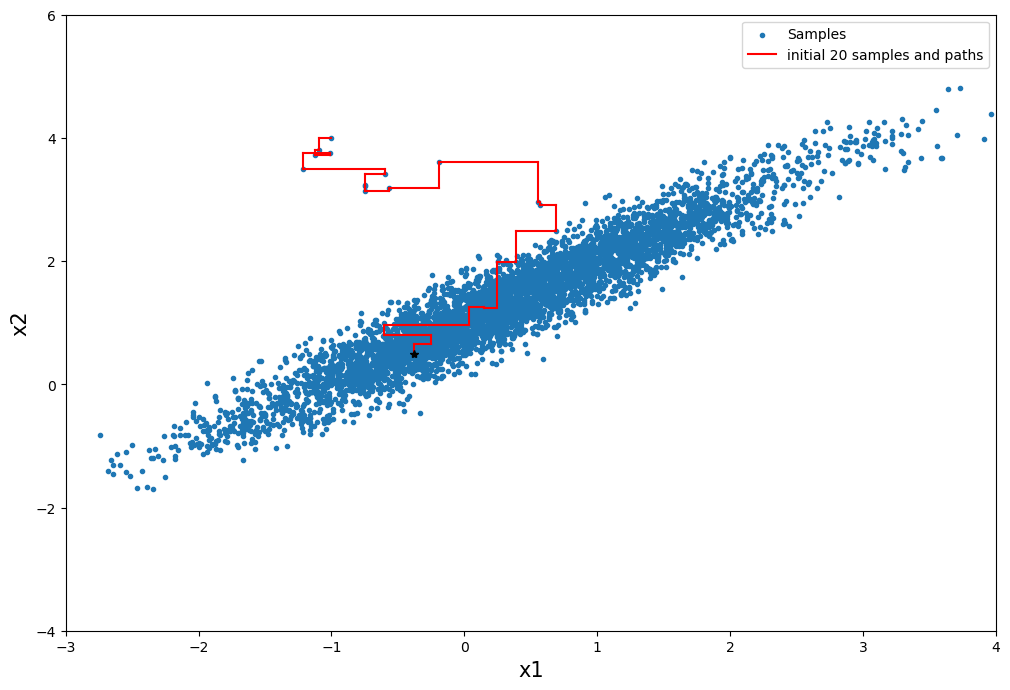

In [8]:
plt.figure(figsize = (12, 8))
plt.scatter(xx, yy, marker = '.')
for t in range(20):
    plt.plot([xx[t], xx[t+1]], [yy[t], yy[t]], 'r-')
    plt.plot([xx[t+1], xx[t+1]], [yy[t], yy[t+1]], 'r-')
plt.plot(xx[t+1], yy[t+1], 'k*')

plt.legend(['Samples', 'initial 20 samples and paths'])
plt.xlabel('x1', fontsize = 15)
plt.ylabel('x2', fontsize = 15)
plt.xlim([-3, 4])
plt.ylim([-4, 6])

In [9]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    ax_histx.tick_params(axis='x', labelbottom=False)
    ax_histy.tick_params(axis='y', labelleft=False)

    ax.scatter(x, y, marker='.')
    ax.set_xlim((-3,4))

    ax.set_ylim((-4,6))
    ax.set_xlabel('X1', fontsize = 15)
    ax.set_ylabel('X2', fontsize = 15)
    
    binwidth = 0.10
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth)+1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins, density = True)
    ax_histy.hist(y, bins=bins, orientation = 'horizontal', density = True)

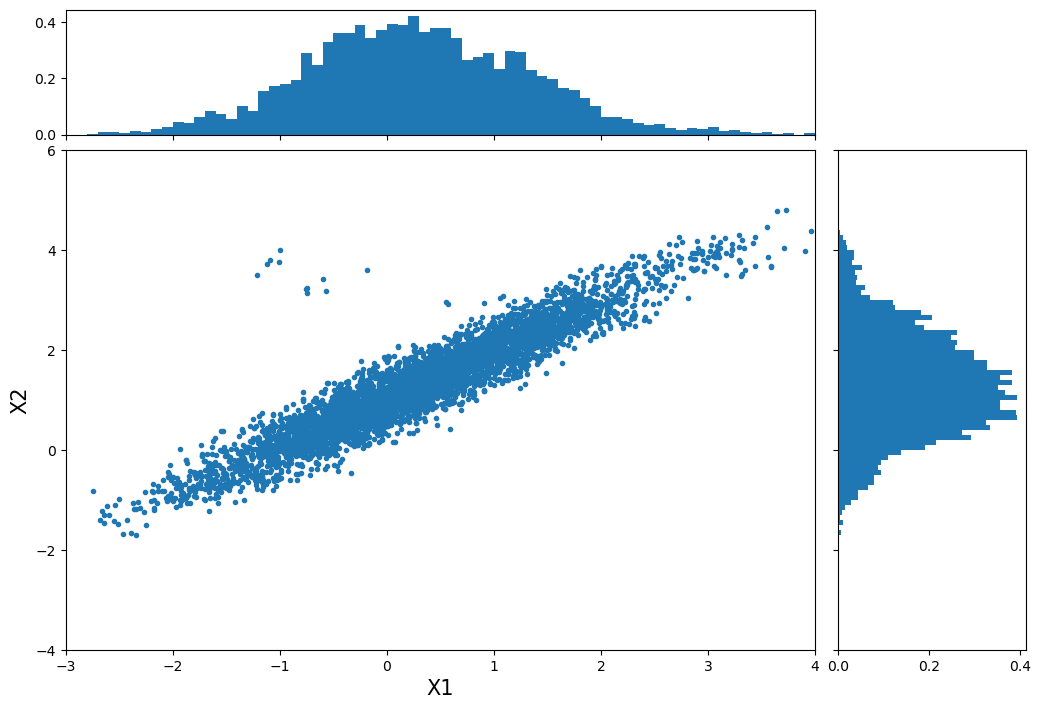

In [10]:
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex = ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey = ax)
scatter_hist(xx, yy, ax, ax_histx, ax_histy)

Text(0.5, 1.0, 'Sample Autocorrealtion Function')

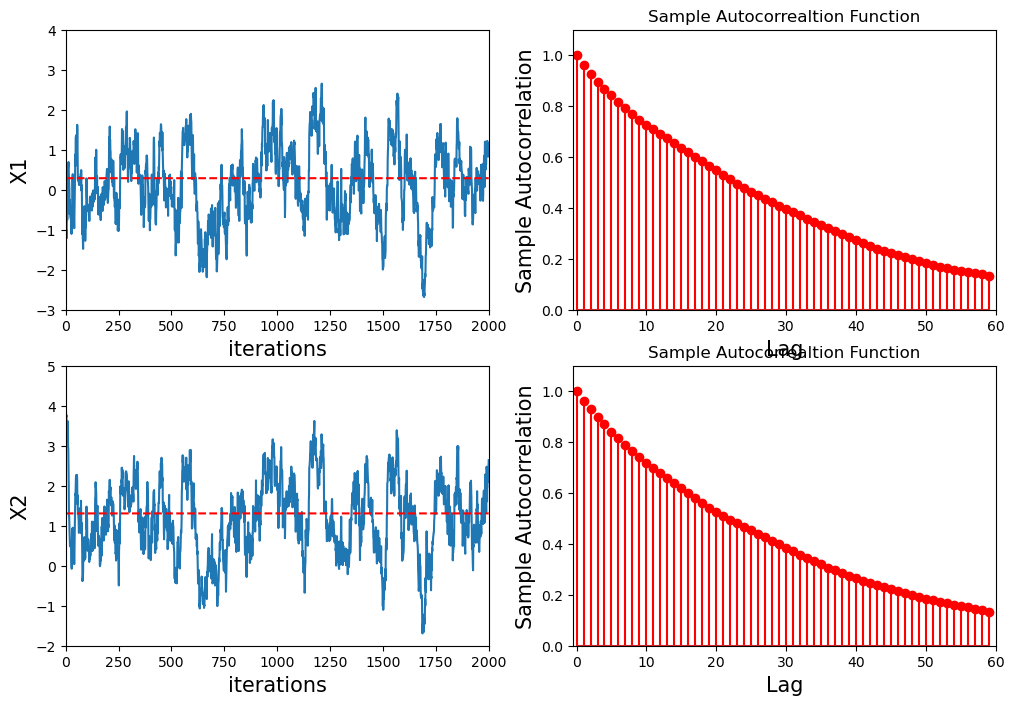

In [11]:
plt.figure(figsize = (12, 8))
plt.subplot(2,2,1)
plt.plot(np.arange(T), xx)
plt.plot(np.arange(T), np.mean(xx)*np.ones(T), 'r--')
plt.xlabel('iterations', fontsize = 15)
plt.ylabel('X1', fontsize = 15)
plt.xlim((0, 2000))
plt.ylim((-3, 4))

plt.subplot(2,2,2)
plt.stem(np.arange(60), autocorr1(xx, np.arange(60)), linefmt ='r', markerfmt='ro')
plt.xlabel('Lag', fontsize = 15)
plt.ylabel('Sample Autocorrelation', fontsize = 15)
plt.xlim((-0.5, 60))
plt.ylim((0, 1.1))

plt.title('Sample Autocorrealtion Function')

plt.subplot(2,2,3)
plt.plot(np.arange(T), yy)
plt.plot(np.arange(T), np.mean(yy)*np.ones(T), 'r--')
plt.xlabel('iterations', fontsize = 15)
plt.ylabel('X2', fontsize = 15)
plt.xlim((0, 2000))
plt.ylim((-2, 5))

plt.subplot(2,2,4)
plt.stem(np.arange(60), autocorr1(yy, np.arange(60)), linefmt ='r', markerfmt='ro')
plt.xlabel('Lag', fontsize = 15)
plt.ylabel('Sample Autocorrelation', fontsize = 15)
plt.xlim((-0.5, 60))
plt.ylim((0, 1.1))
plt.title('Sample Autocorrealtion Function')

# 3) (w/ Stepping-Out) Slice Sampling for 2-D Normal Distribution

In [12]:
T = 5000
d = 2

# target distribution: bi-variate normal distribution with correlation
pMu = np.array([0.5, 1.5])
pSigma = np.array([[1, 0.95], [0.95, 1]])

def p(x):
    return multivariate_normal(mean=pMu, cov=pSigma).pdf(x)

x = np.zeros((T, d))
xL, xR, W, r = np.zeros((1, d)), np.zeros((1, d)), np.zeros((1, d)), np.zeros((1, d))

# ranges from each sample space
xMin = np.array([-3, -4])
xMax = np.array([4, 6])
# initial step sizes (width) for each variable
W = np.array([1, 1])

# select initial points for each sample space
x[0, :] = [-1, 4]
maxiter = 200


for t in range(1, T):
    iter_ = 0

    # selet a random height at the vertical slice (log-scale)
    u[t-1] = np.exp( np.log( p(x[t-1,:]) ) - np.random.exponential(1) )

    # for each dimension
    # set the intervals of hyper-rectangle around the current point
    r = np.random.uniform(0, 1, d)
    xL = np.max(np.concatenate(([xMin], [x[t-1,:]-np.multiply(r, W)]), axis=0), axis=0)
    xR = np.min(np.concatenate(([xMax], [xL+W]), axis=0), axis=0)

    ######## w/ stepping out #########
    while ( u[t-1] < np.exp( np.log( p(xL) )) ) & ( iter_ < maxiter ):
        xL = np.max( np.concatenate(([xMin], [xL-W]), axis=0), axis=0)
        iter_ += 1
    while ( u[t-1] < np.exp( np.log( p(xR) )) ) & ( iter_ < maxiter ):
        xR = np.min( np.concatenate(([xMax], [xR+W]), axis=0), axis=0)
        iter_ += 1
    if iter_ > maxiter:
        print('error in stepping out')

    # accept/reject samples from within S
    while 1:
        # draw candidate sample points from the horizontal slice for each dimension
        xStar = np.random.uniform(xL, xR)

        # evaluate the pdf and determine accepting the candidate point
        if u[t-1] < np.exp( np.log( p(xStar) )):
            x[t,:] = xStar
            break

        # shrinkage procedure
        # modify either the lower or upper end of the interval for each dimension
        for j in range(d):
            if xStar[j] < x[t-1, j]:
                xL[j] = xStar[j]
            else:
                xR[j] = xStar[j]

xx, yy = x[:,0], x[:,1]

(-4.0, 6.0)

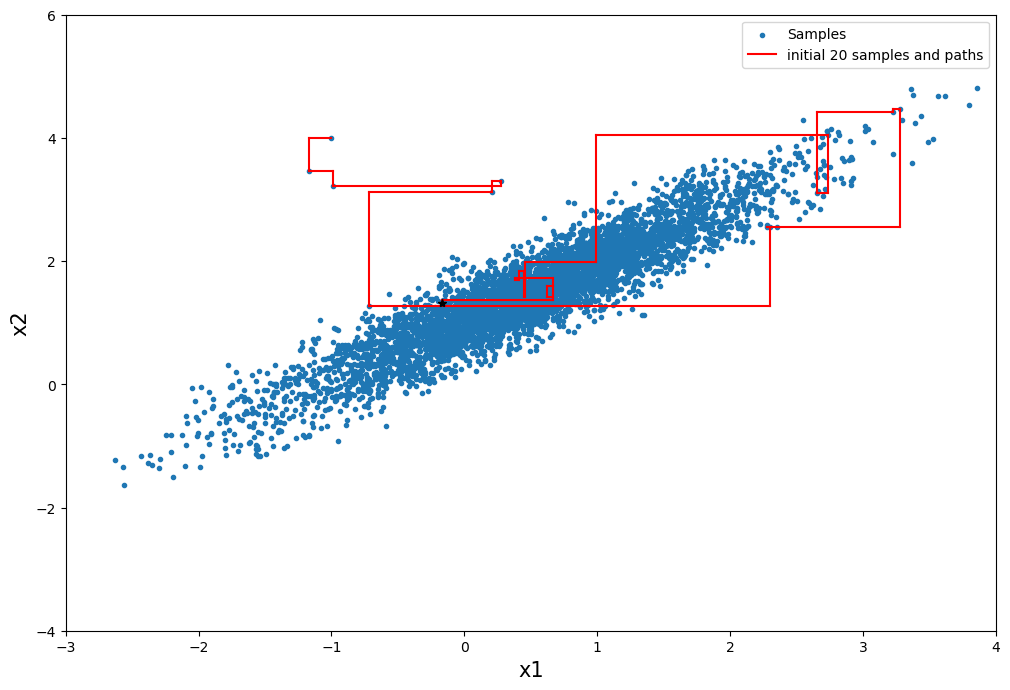

In [13]:
plt.figure(figsize = (12, 8))
plt.scatter(xx, yy, marker = '.')
for t in range(20):
    plt.plot([xx[t], xx[t+1]], [yy[t], yy[t]], 'r-')
    plt.plot([xx[t+1], xx[t+1]], [yy[t], yy[t+1]], 'r-')
plt.plot(xx[t+1], yy[t+1], 'k*')

plt.legend(['Samples', 'initial 20 samples and paths'])
plt.xlabel('x1', fontsize = 15)
plt.ylabel('x2', fontsize = 15)
plt.xlim([-3, 4])
plt.ylim([-4, 6])

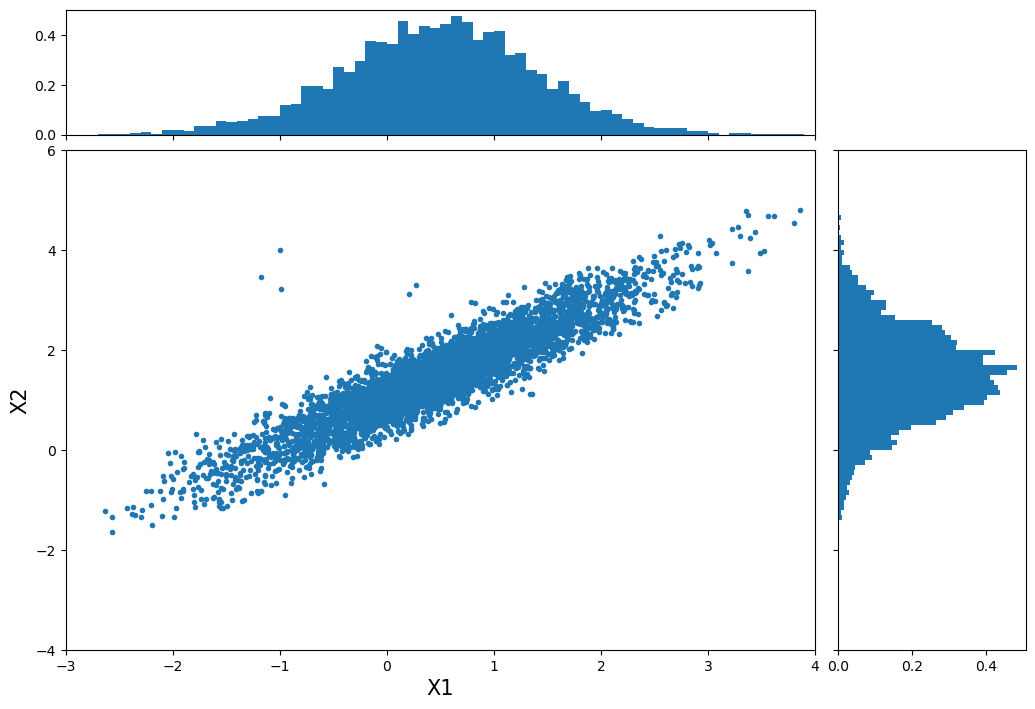

In [14]:
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex = ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey = ax)
scatter_hist(xx, yy, ax, ax_histx, ax_histy)

Text(0.5, 1.0, 'Sample Autocorrealtion Function')

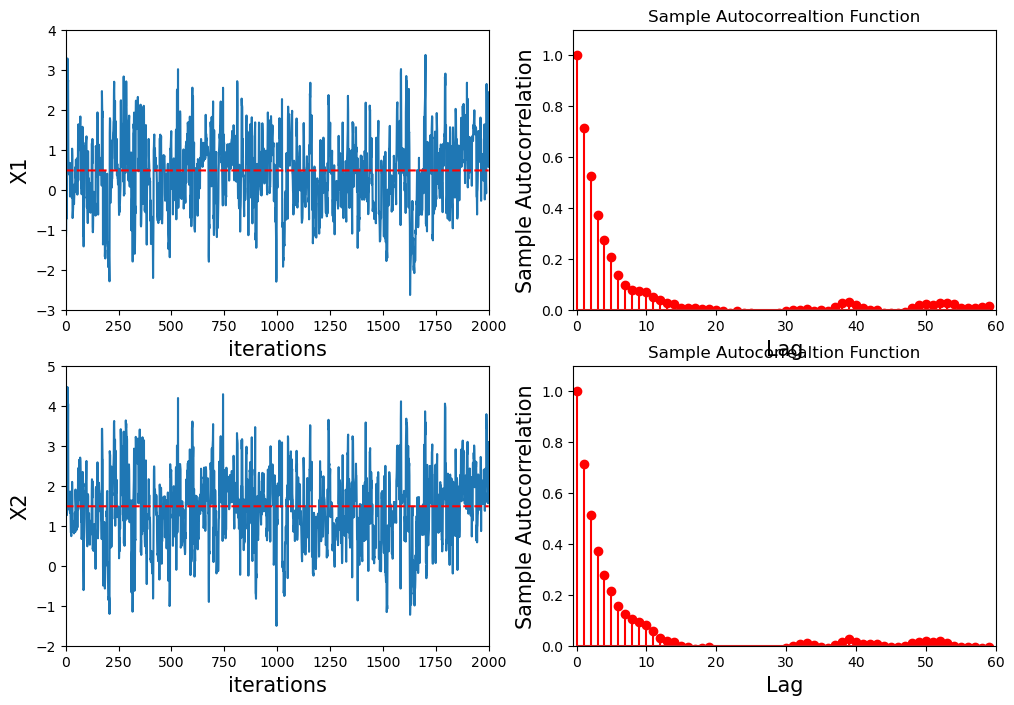

In [15]:
plt.figure(figsize = (12, 8))
plt.subplot(2,2,1)
plt.plot(np.arange(T), xx)
plt.plot(np.arange(T), np.mean(xx)*np.ones(T), 'r--')
plt.xlabel('iterations', fontsize = 15)
plt.ylabel('X1', fontsize = 15)
plt.xlim((0, 2000))
plt.ylim((-3, 4))

plt.subplot(2,2,2)
plt.stem(np.arange(60), autocorr1(xx, np.arange(60)), linefmt ='r', markerfmt='ro')
plt.xlabel('Lag', fontsize = 15)
plt.ylabel('Sample Autocorrelation', fontsize = 15)
plt.xlim((-0.5, 60))
plt.ylim((0, 1.1))

plt.title('Sample Autocorrealtion Function')

plt.subplot(2,2,3)
plt.plot(np.arange(T), yy)
plt.plot(np.arange(T), np.mean(yy)*np.ones(T), 'r--')
plt.xlabel('iterations', fontsize = 15)
plt.ylabel('X2', fontsize = 15)
plt.xlim((0, 2000))
plt.ylim((-2, 5))

plt.subplot(2,2,4)
plt.stem(np.arange(60), autocorr1(yy, np.arange(60)), linefmt ='r', markerfmt='ro')
plt.xlabel('Lag', fontsize = 15)
plt.ylabel('Sample Autocorrelation', fontsize = 15)
plt.xlim((-0.5, 60))
plt.ylim((0, 1.1))
plt.title('Sample Autocorrealtion Function')